In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [300]:
diabetes = pd.read_csv('diabetes.csv')

In [301]:
diabetes.describe()
# Shows Insluin with a std of 115.244, most prone to having outliers

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Analyzing outliers with 3 methods:

### 1. Z-Score Approximation

In [302]:
from scipy import stats

def z_score_approximation(df, col_name):
     data = df
     # Calculate mean and standard deviation of the data
     data_mean = data.describe()[col_name]['mean']
     data_std = data.describe()[col_name]['std']
     alpha = 0.05
     z_score_threshold = stats.norm.ppf(1 - alpha/2)  # Two-tailed test

     # Calculate the threshold for outliers
     threshold_upper = data_mean + z_score_threshold * data_std
     threshold_lower = data_mean - z_score_threshold * data_std

     return threshold_lower, threshold_upper


In [303]:
for i in diabetes.columns:
    print("Thresholds of {} : ({:.2f}, {:.2f})".format(i, *z_score_approximation(diabetes,i)))

Thresholds of Pregnancies : (-2.76, 10.45)
Thresholds of Glucose : (58.23, 183.56)
Thresholds of BloodPressure : (31.17, 107.04)
Thresholds of SkinThickness : (-10.73, 51.80)
Thresholds of Insulin : (-146.07, 305.67)
Thresholds of BMI : (16.54, 47.45)
Thresholds of DiabetesPedigreeFunction : (-0.18, 1.12)
Thresholds of Age : (10.19, 56.29)
Thresholds of Outcome : (-0.59, 1.28)


### 2. Boxplot (Interquartile Range - IQR) Method

In [304]:
def outlier_thresholds(df, col_name):
  data_qtles = df.describe()
  q1 = data_qtles[col_name]['25%']
  q3 = data_qtles[col_name]['75%']
  IQR = q3 - q1
  up_limit = q3 + 1.5*IQR
  low_limit = q1 - 1.5*IQR
  return low_limit, up_limit

In [305]:
for i in diabetes.columns:
    print("Thresholds of {} : ({:.2f}, {:.2f})".format(i, *outlier_thresholds(diabetes,i)))

Thresholds of Pregnancies : (-6.50, 13.50)
Thresholds of Glucose : (37.12, 202.12)
Thresholds of BloodPressure : (35.00, 107.00)
Thresholds of SkinThickness : (-48.00, 80.00)
Thresholds of Insulin : (-190.88, 318.12)
Thresholds of BMI : (13.35, 50.55)
Thresholds of DiabetesPedigreeFunction : (-0.33, 1.20)
Thresholds of Age : (-1.50, 66.50)
Thresholds of Outcome : (-1.50, 2.50)


# Missing Values

In [306]:
num_cols = len(diabetes.columns)

In [307]:
num_cols_miss = [i for i in diabetes.columns if i != ("Pregnancies") and i != "Outcome"]
# prints:
# ['Glucose',
#  'BloodPressure',
#  'SkinThickness',
#  'Insulin',
#  'BMI',
#  'DiabetesPedigreeFunction',
#  'Age']
for i in num_cols_miss:
    diabetes[i] = diabetes.apply(lambda x: np.nan if x[i] == 0 else x[i], axis=1)

In [308]:
diabetes.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [309]:
!pip install missingno
import missingno as msno

<Axes: >

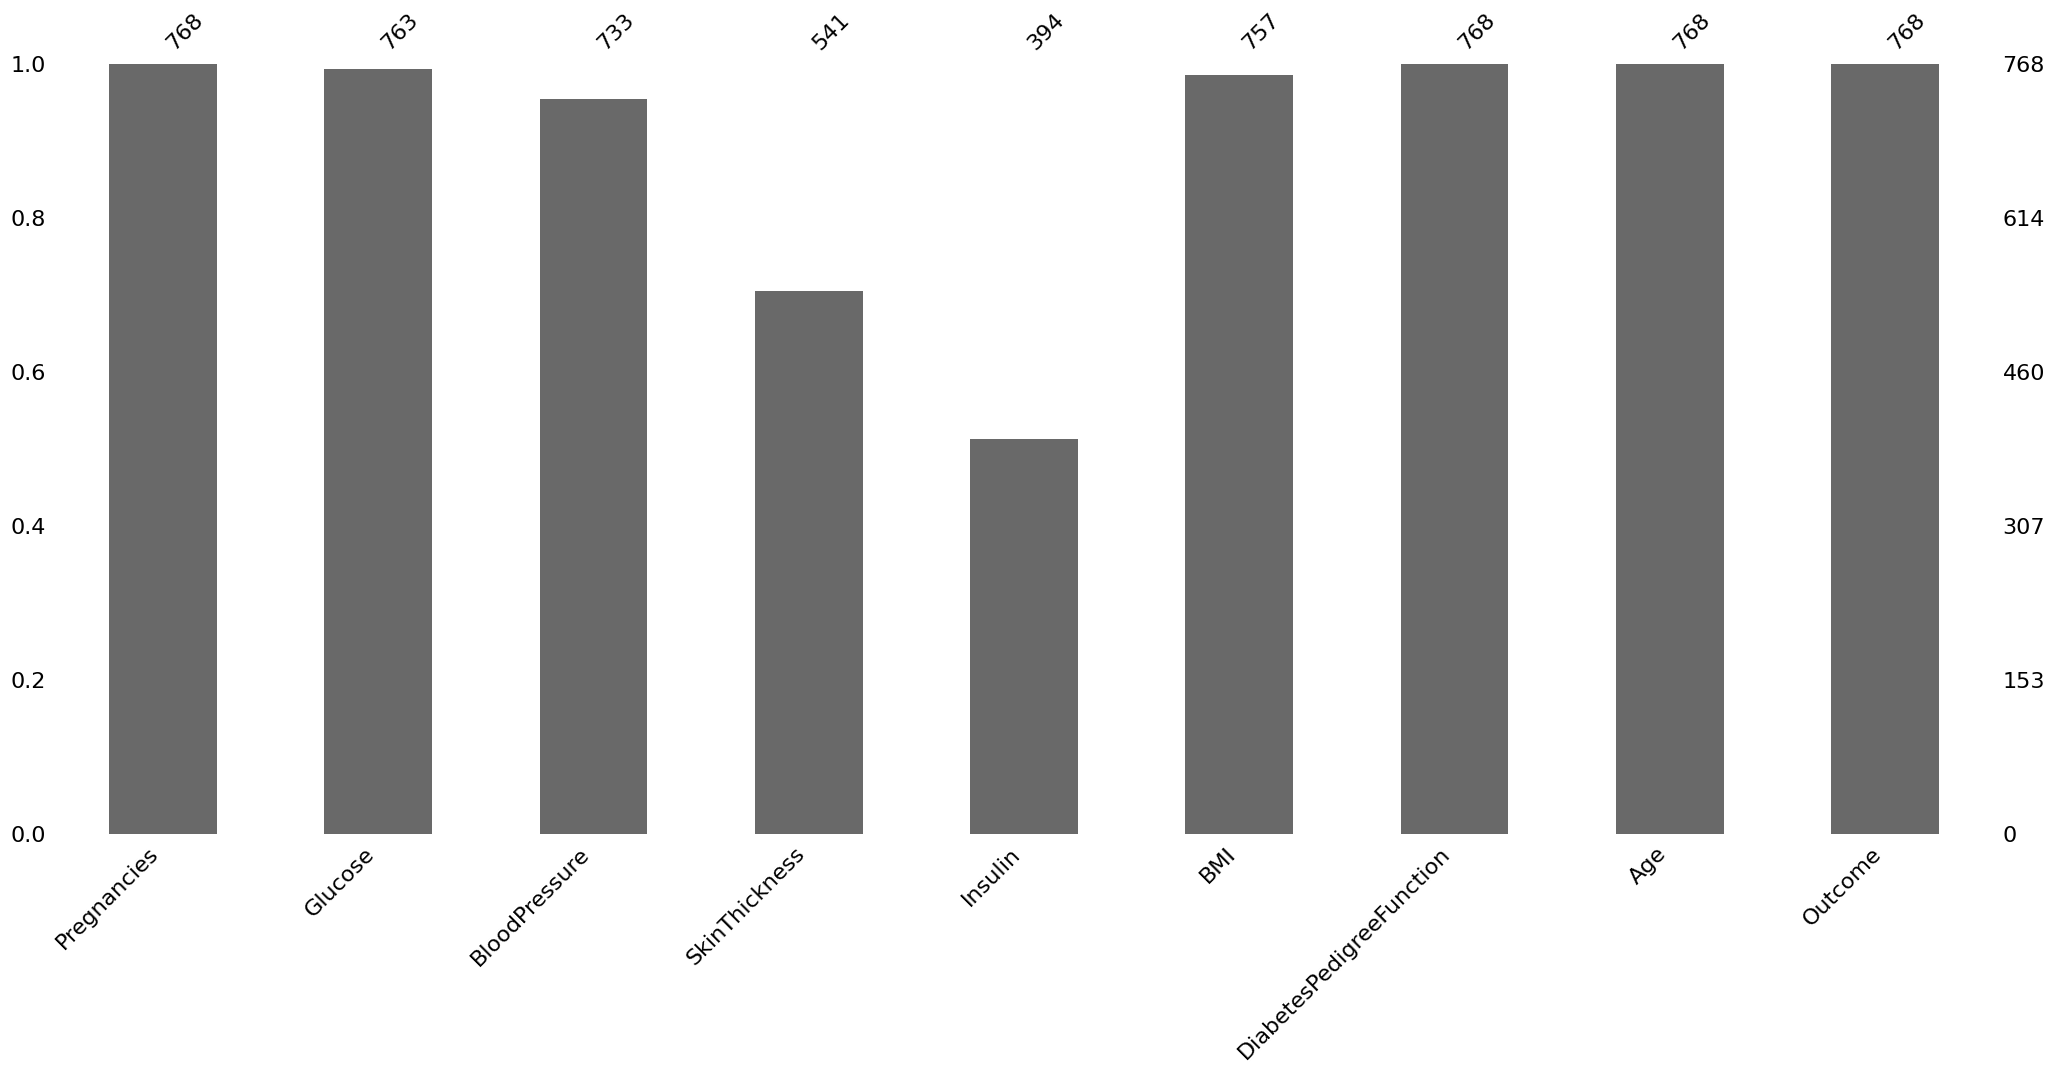

In [310]:
# the number of non-missing data
msno.bar(diabetes)

<Axes: >

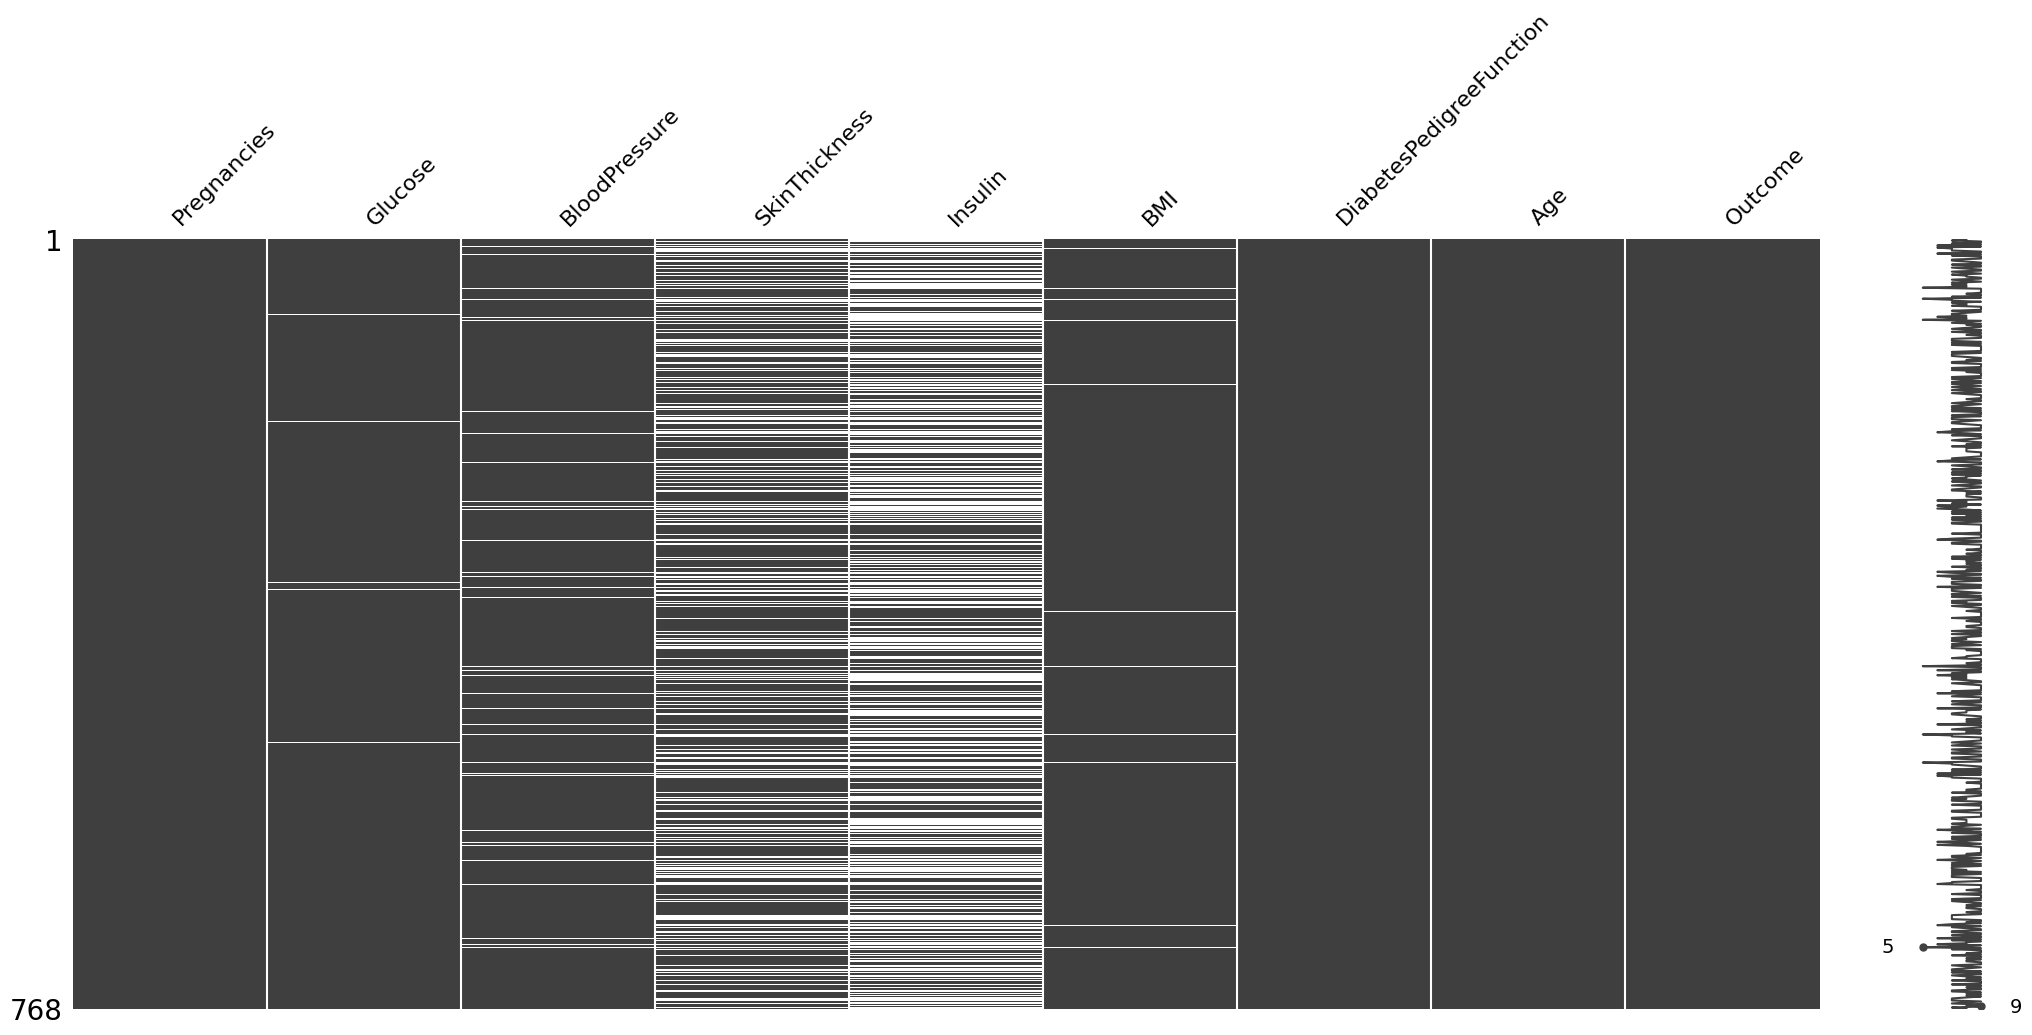

In [311]:
msno.matrix(diabetes)

<Axes: >

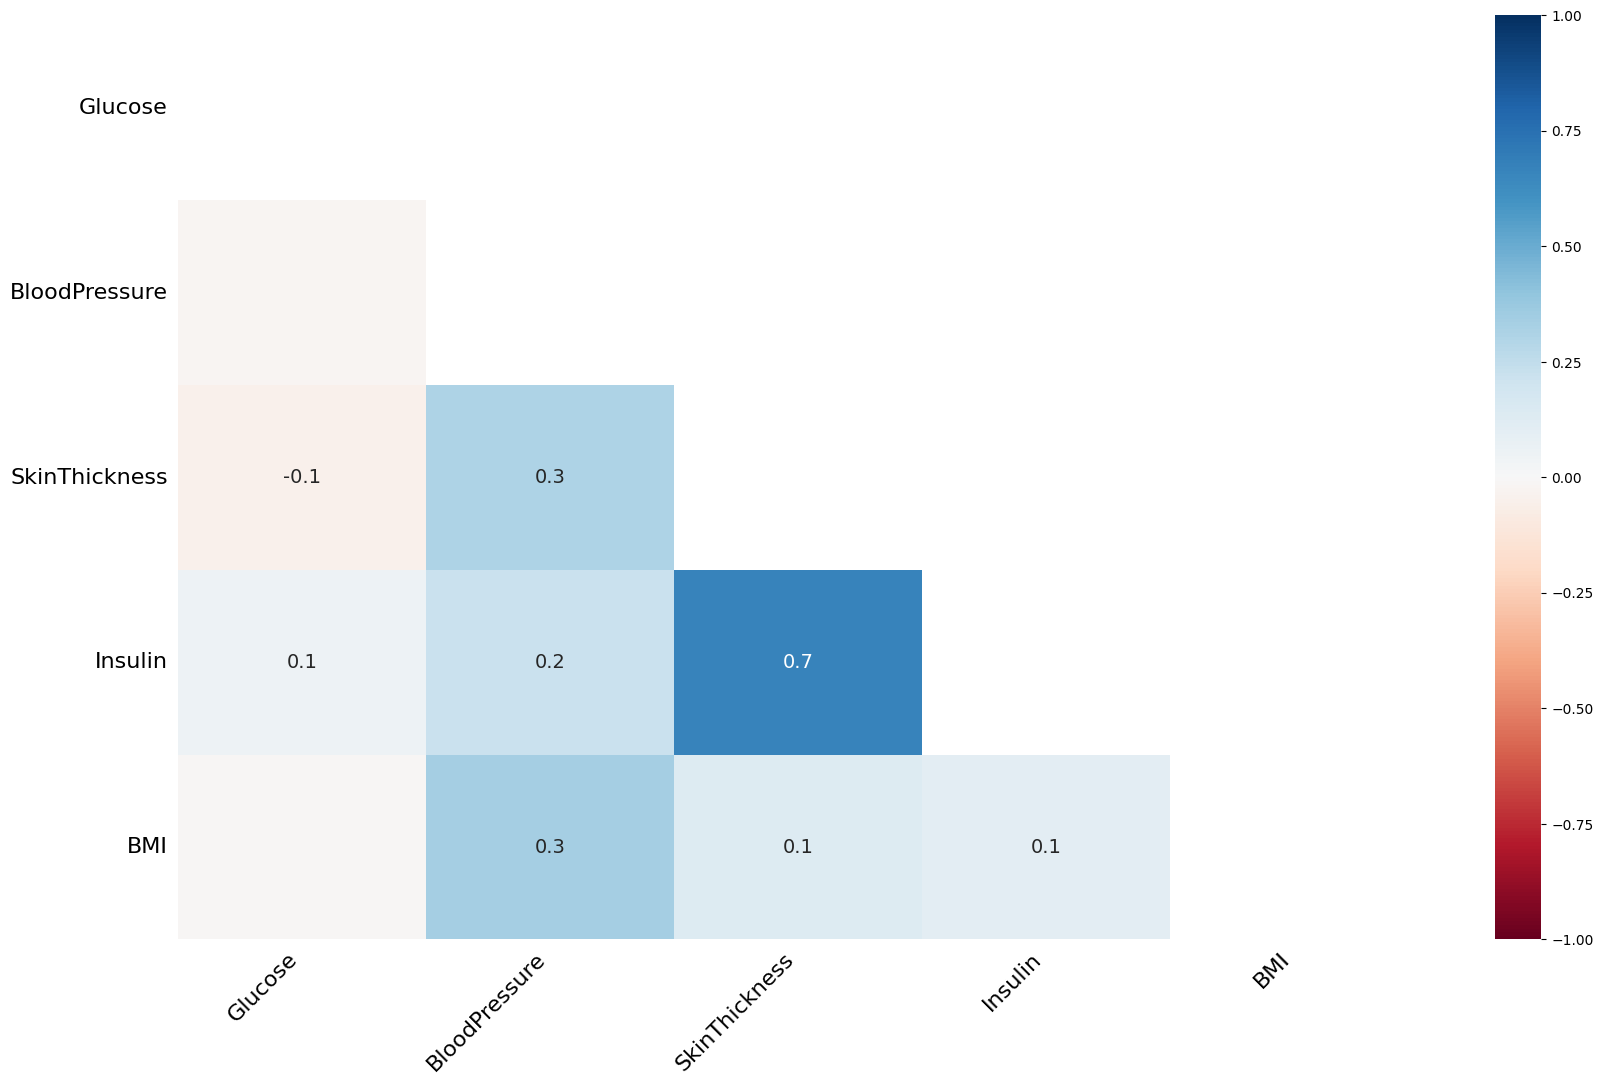

In [312]:
msno.heatmap(diabetes)

In [313]:
def missing_values_table(dataframe, na_name=False):
    # only take missing columns
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)  # number of missing value
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False) # ratio
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])  # make table
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [314]:
na_cols = missing_values_table(diabetes, na_name=True)
diabetes[na_cols].isnull()

               n_miss  ratio
Insulin           374  48.70
SkinThickness     227  29.56
BloodPressure      35   4.56
BMI                11   1.43
Glucose             5   0.65


,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,False,False,False,True,False
1,False,False,False,True,False
2,False,False,True,True,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
763,False,False,False,False,False
764,False,False,False,True,False
765,False,False,False,False,False
766,False,False,True,True,False


In [315]:
def missing_target(df, target, na_col):
  df_temp = df.copy()
  for col in na_cols:
    df_temp[col + '_NA_FLAG'] = np.where(df_temp[col].isnull(),1,0)
  na_flags = df_temp.loc[:, df_temp.columns.str.contains("_NA_")].columns
  print("COLUMNS CONTAINING N.A :", na_flags)
  for col in na_flags:
        print(df_temp.groupby(col)[target].sum().head())

        print(pd.DataFrame(
              {
                "TARGET_MEAN": df_temp.groupby(col)[target].mean(),
                "Count": df_temp.groupby(col)[target].count()
              }
            ), end="\n\n\n")

In [316]:
missing_target(diabetes,"Outcome",na_cols)

COLUMNS CONTAINING N.A : Index(['Glucose_NA_FLAG', 'BloodPressure_NA_FLAG', 'SkinThickness_NA_FLAG',
       'Insulin_NA_FLAG', 'BMI_NA_FLAG'],
      dtype='object')
Glucose_NA_FLAG
0    266
1      2
Name: Outcome, dtype: int64
                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                   0.348624    763
1                   0.400000      5


BloodPressure_NA_FLAG
0    252
1     16
Name: Outcome, dtype: int64
                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                         0.343793    733
1                         0.457143     35


SkinThickness_NA_FLAG
0    180
1     88
Name: Outcome, dtype: int64
                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                         0.332717    541
1                         0.387665    227


Insulin_NA_FLAG
0    130
1    138
Name: Outcome, dtype: int64
                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                

In [317]:
corr_matrix = diabetes.corr()
corr_matrix["Outcome"].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.494650
BMI                         0.313680
Insulin                     0.303454
SkinThickness               0.259491
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
BloodPressure               0.170589
Name: Outcome, dtype: float64

In [318]:
from sklearn.preprocessing import MinMaxScaler

In [319]:
df_ml = diabetes.copy()

# standardization
scaler = MinMaxScaler()
df_ml = pd.DataFrame(scaler.fit_transform(df_ml), columns=df_ml.columns)
df_ml.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.670968,0.489796,0.304348,NaN,0.314928,0.234415,0.483333,1.0
1,0.058824,0.264516,0.428571,0.239130,NaN,0.171779,0.116567,0.166667,0.0
2,0.470588,0.896774,0.408163,NaN,NaN,0.104294,0.253629,0.183333,1.0
3,0.058824,0.290323,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000,0.0
4,0.000000,0.600000,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000,1.0


In [320]:
# Fill NaN with KNN Algorithm
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_ml = pd.DataFrame(imputer.fit_transform(df_ml), columns=df_ml.columns)
df_ml.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.670968,0.489796,0.304348,0.384856,0.314928,0.234415,0.483333,1.0
1,0.058824,0.264516,0.428571,0.239130,0.050721,0.171779,0.116567,0.166667,0.0
2,0.470588,0.896774,0.408163,0.273913,0.269231,0.104294,0.253629,0.183333,1.0
3,0.058824,0.290323,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000,0.0
4,0.000000,0.600000,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000,1.0


In [321]:
# Reverse transformed data
df_ml = pd.DataFrame(scaler.inverse_transform(df_ml), columns=df_ml.columns)
df_ml.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,334.2,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,56.2,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,32.2,238.0,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0


# Feature Extraction


In [322]:
# Cleaned database
diabetes = pd.read_csv('diabetes.csv')
diabetes_data = diabetes.copy(deep = True)
#Replace the zero values to Nan, it is easy to count the null values
diabetes_data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = diabetes_data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

### Using 200 values as a threshold for missing values since we conclude it's a health dataset we are dealing with

In [323]:
na_cols = missing_values_table(diabetes_data, na_name=True) # columns that includes missing values
n_miss = diabetes_data[na_cols].isnull().sum() # number of missing values on variables

# 100 as a threshold, it is open to comment
na_cols_ml = [i for i in n_miss.index if n_miss[i] < 200]
na_cols_med = [i for i in n_miss.index if n_miss[i] > 200]
print("Columns that will be applied ML model:", na_cols_ml)
print("Columns that will be filled with median:", na_cols_med)

               n_miss  ratio
Insulin           374  48.70
SkinThickness     227  29.56
BloodPressure      35   4.56
BMI                11   1.43
Glucose             5   0.65
Columns that will be applied ML model: ['Glucose', 'BloodPressure', 'BMI']
Columns that will be filled with median: ['SkinThickness', 'Insulin']


In [324]:
medians = diabetes_data.median()
medians

Pregnancies                   3.0000
Glucose                     117.0000
BloodPressure                72.0000
SkinThickness                29.0000
Insulin                     125.0000
BMI                          32.3000
DiabetesPedigreeFunction      0.3725
Age                          29.0000
Outcome                       0.0000
dtype: float64

In [325]:
for cols in na_cols_med:
  diabetes_data[cols] = diabetes_data[cols].fillna(medians[cols])

In [326]:
scaler = MinMaxScaler()
diabetes_data[na_cols_ml] = pd.DataFrame(scaler.fit_transform(diabetes_data[na_cols_ml]), columns=diabetes_data[na_cols_ml].columns)
print(diabetes_data[na_cols_ml].head())

    Glucose  BloodPressure       BMI
0  0.670968       0.489796  0.314928
1  0.264516       0.428571  0.171779
2  0.896774       0.408163  0.104294
3  0.290323       0.428571  0.202454
4  0.600000       0.163265  0.509202


In [327]:
imputer = KNNImputer(n_neighbors=5)
diabetes_data[na_cols_ml] = pd.DataFrame(imputer.fit_transform(diabetes_data[na_cols_ml]), columns=diabetes_data[na_cols_ml].columns)
print(diabetes_data[na_cols_ml].head())

    Glucose  BloodPressure       BMI
0  0.670968       0.489796  0.314928
1  0.264516       0.428571  0.171779
2  0.896774       0.408163  0.104294
3  0.290323       0.428571  0.202454
4  0.600000       0.163265  0.509202


In [328]:
diabetes_data[na_cols_ml] = pd.DataFrame(scaler.inverse_transform(diabetes_data[na_cols_ml]), columns=diabetes_data[na_cols_ml].columns)
print(diabetes_data[na_cols_ml].head())

   Glucose  BloodPressure   BMI
0    148.0           72.0  33.6
1     85.0           66.0  26.6
2    183.0           64.0  23.3
3     89.0           66.0  28.1
4    137.0           40.0  43.1


In [329]:
diabetes_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,121.674219,30.445229,44.000,99.75000,117.0000,140.25000,199.00
BloodPressure,768.0,72.408073,12.203100,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,768.0,29.108073,8.791221,7.000,25.00000,29.0000,32.00000,99.00
Insulin,768.0,140.671875,86.383060,14.000,121.50000,125.0000,127.25000,846.00
BMI,768.0,32.455703,6.883265,18.200,27.50000,32.3000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [330]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


### Applying LOF Method again, after imputing missing values

In [331]:
lof.fit_predict(diabetes_data)  # returns LOF scores
df_scores = lof.negative_outlier_factor_ # keep scores to observe (negative)

In [332]:
len(df_scores)

768

In [333]:
df_scores

array([-1.01906445, -0.99409969, -1.0618044 , -0.99163597, -1.27904191,
       -0.97128896, -1.1089918 , -1.00348171, -1.24064769, -1.14063425,
       -1.09671075, -0.97663031, -1.04008144, -2.59693313, -1.0857331 ,
       -0.99648909, -1.0650121 , -0.98194987, -1.49632425, -1.01805197,
       -1.05772178, -1.03248834, -1.07503642, -1.05006159, -1.26345491,
       -1.06208584, -0.99975993, -1.34854894, -1.19852736, -1.0769009 ,
       -1.05181828, -1.04146486, -0.96641051, -1.37325491, -1.01483629,
       -1.01362057, -0.99102249, -1.01821415, -1.11858711, -1.07268205,
       -1.78813655, -1.00065524, -1.22336943, -1.15637862, -1.01233728,
       -1.06042246, -1.08879832, -1.09531828, -1.03605961, -0.95651573,
       -1.07354912, -1.09754763, -1.13968333, -0.9984802 , -1.04953709,
       -1.49226736, -1.00510327, -1.62979205, -1.01863976, -1.46433427,
       -1.05151976, -0.99980038, -1.6458485 , -1.12121517, -1.01712843,
       -0.99894573, -1.09123479, -1.14060708, -1.011944  , -1.51

In [334]:
print(df_scores[0:5])
print(np.sort(df_scores)[0:5])

[-1.01906445 -0.99409969 -1.0618044  -0.99163597 -1.27904191]
[-2.80654993 -2.59693313 -2.4153327  -2.02249122 -1.99003552]


<Axes: >

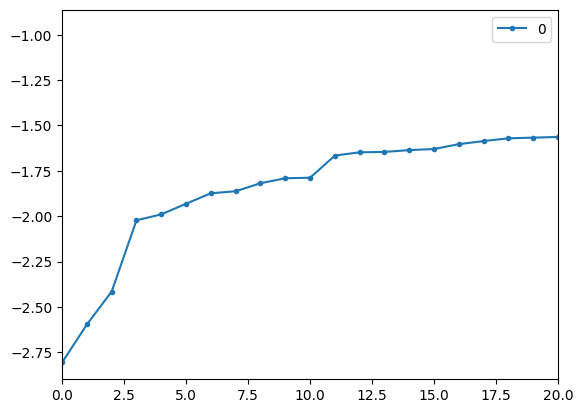

In [335]:
# elbow method
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 20], style='.-')

In [336]:
th = np.sort(df_scores)[3]
th

-2.0224912163725586

In [337]:
diabetes_data[df_scores < th]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
13,1,189.0,60.0,23.0,846.0,30.1,0.398,59,1
445,0,180.0,78.0,63.0,14.0,59.4,2.420,25,1
579,2,197.0,70.0,99.0,125.0,34.7,0.575,62,1


In [345]:
diabetes_data.describe([0.01, 0.05, 0.25, 0.50, 0.75, 0.90, 0.99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,90%,99%,max
Pregnancies,765.0,3.856209,3.371070,0.000,0.00000,0.0000,1.000,3.00,6.000,9.0000,13.00000,17.000
Glucose,765.0,121.411503,30.210433,44.000,67.64000,80.0000,99.000,117.00,140.000,166.0000,195.36000,199.000
BloodPressure,765.0,72.420131,12.216801,24.000,44.00000,52.0000,64.000,72.00,80.000,88.0000,106.00000,122.000
SkinThickness,765.0,28.980392,8.344254,7.000,10.00000,14.2000,25.000,29.00,32.000,40.0000,50.00000,60.000
Insulin,765.0,139.935948,82.573035,15.000,27.56000,50.2000,122.000,125.00,127.000,210.0000,500.40000,744.000
BMI,765.0,32.420627,6.826423,18.200,19.50000,22.2200,27.500,32.30,36.600,41.4200,49.80800,67.100
DiabetesPedigreeFunction,765.0,0.469292,0.324368,0.078,0.09456,0.1402,0.243,0.37,0.626,0.8768,1.63528,2.329
Age,765.0,33.180392,11.696260,21.000,21.00000,21.0000,24.000,29.00,41.000,51.0000,67.00000,81.000
Outcome,765.0,0.346405,0.476135,0.000,0.00000,0.0000,0.000,0.00,1.000,1.0000,1.00000,1.000


In [346]:
print("Before delete outliers:", diabetes_data.shape)
print(diabetes_data[df_scores < th].index) # indexes of outliers, just for observation
diabetes_data.drop(axis=0, labels=diabetes_data[df_scores < th].index, inplace=True)
print("After delete outliers:", diabetes_data.shape)

Before delete outliers: (765, 9)


ValueError: Item wrong length 768 instead of 765.

### Now using IQR Method

In [293]:
# take the computed threshold and re-assign the outliers
def replace_with_thresholds(df, variable):
    low_limit, up_limit = outlier_thresholds(df, variable)
    df.loc[(df[variable] < low_limit), variable] = low_limit
    df.loc[(df[variable] > up_limit), variable] = up_limit

In [294]:
diabetes_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,765.0,3.856209,3.371070,0.000,1.000,3.00,6.000,17.000
Glucose,765.0,121.411503,30.210433,44.000,99.000,117.00,140.000,199.000
BloodPressure,765.0,72.420131,12.216801,24.000,64.000,72.00,80.000,122.000
SkinThickness,765.0,28.980392,8.344254,7.000,25.000,29.00,32.000,60.000
Insulin,765.0,139.935948,82.573035,15.000,122.000,125.00,127.000,744.000
BMI,765.0,32.420627,6.826423,18.200,27.500,32.30,36.600,67.100
DiabetesPedigreeFunction,765.0,0.469292,0.324368,0.078,0.243,0.37,0.626,2.329
Age,765.0,33.180392,11.696260,21.000,24.000,29.00,41.000,81.000
Outcome,765.0,0.346405,0.476135,0.000,0.000,0.00,1.000,1.000


In [295]:
num_cols = []
for col in diabetes_data.columns:
  if col != 'Outcome':
    num_cols.append(col)
print(num_cols)

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [235]:
for col in num_cols:
    replace_with_thresholds(diabetes_data, col)

/Users/fernankiwi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/fernankiwi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/fernankiwi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/fernankiwi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/fernankiwi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/fernankiwi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/numpy

KeyError: 'Glucose_Trend'

# Feature Extraction

- [1] Insulin Sensitivity: We propose calculating the insulin sensitivity score
- [2] Age groups: We propose having more granularity on the age categories.
- [3] Glucose Category Trends: We propose a feature that indicates if a patient's glucose level has been consistently increasing, decreasing, or stable over a certain period.
- [4] BMI Category: We propose categorizing the BMI into different health categories.

In [209]:
diabetes_data["Pregnancies"] = diabetes_data["Pregnancies"].apply(lambda x: int(x))

In [236]:
# Calculate Insulin Sensitivity
diabetes_data['Insulin_Sensitivity'] = diabetes_data['Glucose'] / (diabetes_data['Insulin'] * diabetes_data['BMI'])

# Glucose Category Trends
diabetes_data['Glucose_Trend'] = np.where(diabetes_data['Glucose'].diff() > 0, 'Increasing',
                                          np.where(diabetes_data['Glucose'].diff() < 0, 'Decreasing', 'Stable'))


In [237]:
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin_Sensitivity,Glucose_Trend,BMI_Category_Normal Weight,BMI_Category_Overweight,BMI_Category_Obese
0,6.0,0.756098,0.000,0.857143,0.0,0.142857,0.671018,1.235294,1,inf,Stable,False,False,True
1,1.0,-0.780488,-0.375,0.000000,0.0,-0.626374,-0.049608,0.117647,0,inf,Decreasing,False,True,False
2,8.0,1.609756,-0.500,0.000000,0.0,-0.989011,0.788512,0.176471,1,-inf,Increasing,True,False,False
3,1.0,-0.682927,-0.375,-0.857143,-2.1,-0.461538,-0.530026,-0.470588,0,-0.704607,Decreasing,False,True,False
4,0.0,0.487805,-2.000,0.857143,1.9,1.186813,2.168407,0.235294,1,0.216327,Increasing,False,False,True


In [239]:
new_cat_columns = []
for cols in diabetes_data.columns:
  #print(diabetes_data[cols])
  if diabetes_data[cols].dtype.name =='category':
    new_cat_columns.append(cols)
print(new_cat_columns)

[]


In [240]:
new_num_data = []
for cols in diabetes_data.columns:
  #print(diabetes_data[cols])
  if diabetes_data[cols].dtype.name =='float64':
    new_num_data.append(cols)
print(new_num_data)

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Insulin_Sensitivity']


In [241]:
df_scale = diabetes_data.copy()

# Encoding & Scaling

In [242]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [243]:
# standart scaler
ss = StandardScaler()
df_scale["Age_standard_scaler"] = ss.fit_transform(df_scale[["Age"]])
df_scale.head()

# robust scaler
rs = RobustScaler()
df_scale["Age_robuts_scaler"] = rs.fit_transform(df_scale[["Age"]])

# min-max scaler
# The range can be given with the feature_range=() argument
mms = MinMaxScaler() # default range from 0 to 1
df_scale["Age_min_max_scaler"] = mms.fit_transform(df_scale[["Age"]])

df_scale.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin_Sensitivity,Glucose_Trend,BMI_Category_Normal Weight,BMI_Category_Overweight,BMI_Category_Obese,Age_standard_scaler,Age_robuts_scaler,Age_min_max_scaler
0,6.0,0.756098,0.000,0.857143,0.0,0.142857,0.671018,1.235294,1,inf,Stable,False,False,True,1.459126,1.235294,0.637363
1,1.0,-0.780488,-0.375,0.000000,0.0,-0.626374,-0.049608,0.117647,0,inf,Decreasing,False,True,False,-0.185127,0.117647,0.219780
2,8.0,1.609756,-0.500,0.000000,0.0,-0.989011,0.788512,0.176471,1,-inf,Increasing,True,False,False,-0.098587,0.176471,0.241758
3,1.0,-0.682927,-0.375,-0.857143,-2.1,-0.461538,-0.530026,-0.470588,0,-0.704607,Decreasing,False,True,False,-1.050523,-0.470588,0.000000
4,0.0,0.487805,-2.000,0.857143,1.9,1.186813,2.168407,0.235294,1,0.216327,Increasing,False,False,True,-0.012048,0.235294,0.263736


In [244]:
rs = RobustScaler()
for i in new_num_data:
    diabetes_data[i] = rs.fit_transform(diabetes_data[[i]])
diabetes_data.head()

/Users/fernankiwi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [245]:
diabetes_data= pd.get_dummies(diabetes_data, columns=new_cat_columns, drop_first=True)
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin_Sensitivity,Glucose_Trend,BMI_Category_Normal Weight,BMI_Category_Overweight,BMI_Category_Obese
0,0.6,0.756098,0.000,0.857143,0.0,0.142857,0.671018,1.235294,1,inf,Stable,False,False,True
1,-0.4,-0.780488,-0.375,0.000000,0.0,-0.626374,-0.049608,0.117647,0,inf,Decreasing,False,True,False
2,1.0,1.609756,-0.500,0.000000,0.0,-0.989011,0.788512,0.176471,1,-inf,Increasing,True,False,False
3,-0.4,-0.682927,-0.375,-0.857143,-2.1,-0.461538,-0.530026,-0.470588,0,-0.704607,Decreasing,False,True,False
4,-0.6,0.487805,-2.000,0.857143,1.9,1.186813,2.168407,0.235294,1,0.216327,Increasing,False,False,True


# Training Models

In [246]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [247]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [248]:
from sklearn.model_selection import cross_val_score

In [251]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

ValueError: could not convert string to float: 'Decreasing'